# en-de time series forecasting example

- data : 삼성 주식 시간별 데이터
- 목적 : 시가, 하한가, 상한가를 이용해 일주일치 종가를 예측
- 참고자료 : https://agupubs.onlinelibrary.wiley.com/doi/pdfdirect/10.1029/2019WR025326

- seq2one 예제

---

# import & read data

In [97]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
import yfinance as yf

`-` 삼성 주식 데이터 불러오기

In [24]:
start_date = '2022-12-31'
end_date ='2024-12-31'

ticker = yf.Ticker('005930.KS')
 
df1= ticker.history(
               interval='1h',
               start=start_date,
               end=end_date,
               actions=True,
               auto_adjust=True)

In [30]:
df1.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-01-02 10:00:00+09:00,55500.0,56100.0,55500.0,55900.0,2981828,0.0,0.0
2023-01-02 11:00:00+09:00,55900.0,56000.0,55800.0,55900.0,1236593,0.0,0.0
2023-01-02 12:00:00+09:00,55800.0,55900.0,55500.0,55500.0,1201020,0.0,0.0
2023-01-02 13:00:00+09:00,55500.0,55700.0,55400.0,55500.0,1206452,0.0,0.0
2023-01-02 14:00:00+09:00,55400.0,55500.0,55200.0,55400.0,1855373,0.0,0.0


<Axes: xlabel='Datetime'>

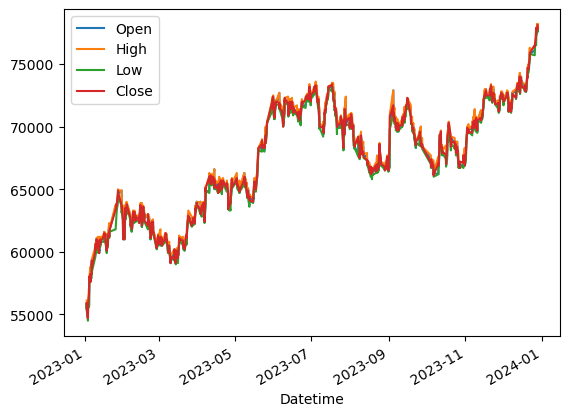

In [16]:
df1.iloc[:,:4].plot()

- feature data : open, high, low
- target data: close
- 목적 : 1~11월의 train data를 이용하여 12월의 target data를 예측
- seq2seq model을 이용하여 예측 모형 생성하기

In [40]:
X = df1.iloc[:,:4].loc[:'2023-11-30 14:00:00+09:00',:]
Y = df1.iloc[:,:4].loc['2023-12-01 10:00:00+09:00':,:]

In [138]:
class WINdow:
    def __init__(self,df,timestep):
        self.df = df
        self.timestep=timestep+1 # 예상한 timestep보다 1적기 때문에 +1
        
    def window(self):
        for i in range(1, self.timestep):
            self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
            self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
        window_df = self.df.dropna(axis=0) # 결측치 공간 제거
        self.window_df = window_df.iloc[:,::-1] # 좌우 반전
        
                
        self.feature= self.window_df.iloc[:,:-1].values
        self.y_label= self.window_df.iloc[:,-1].values
        
        return self. window_df 

# fitting data 전처리

In [280]:
f1 = WINdow(X[['Open']],5)
f2 = WINdow(X[['High']],5)
f3 = WINdow(X[['Low']],5)
f4 = WINdow(X[['Close']],5)
f1.window()
f2.window()
f3.window()
f4.window()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_19024\1267832976.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_19024\1267832976.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_19024\1267832976.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of

,shift_5,shift_4,shift_3,shift_2,shift_1,Close
Datetime,,,,,,
2023-01-03 09:00:00+09:00,55900.0,55900.0,55500.0,55500.0,55400.0,54700.0
2023-01-03 10:00:00+09:00,55900.0,55500.0,55500.0,55400.0,54700.0,54800.0
2023-01-03 11:00:00+09:00,55500.0,55500.0,55400.0,54700.0,54800.0,55100.0
2023-01-03 12:00:00+09:00,55500.0,55400.0,54700.0,54800.0,55100.0,55700.0
2023-01-03 13:00:00+09:00,55400.0,54700.0,54800.0,55100.0,55700.0,55600.0
...,...,...,...,...,...,...
2023-11-30 10:00:00+09:00,72600.0,72300.0,72700.0,72700.0,72400.0,72500.0
2023-11-30 11:00:00+09:00,72300.0,72700.0,72700.0,72400.0,72500.0,72600.0
2023-11-30 12:00:00+09:00,72700.0,72700.0,72400.0,72500.0,72600.0,72400.0


In [560]:
f1234= [f1.feature,f2.feature,f3.feature,f4.feature]

from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
# minmax scale
f1234= [minmax.fit_transform(f1234[i]) for  i in range(len(f1234))]

# 3-dims shape 
f1234reshape = [f1234[i].reshape(-1,5,1) for i in range(len(f1234))]

# 시가
encoder_X1 = np.concatenate([f1234reshape[0]],axis=2)
# 상한가 하한가
encoder_X2 = np.concatenate([f1234reshape[1],f1234reshape[2]],axis=2)
#encoder_X3 = np.concatenate([f1234reshape[2]],axis=2)
# 종가
y_scale = minmax.fit_transform(f4.y_label.reshape(-1, 1))


---

# target data 전처리

In [282]:
t1 = WINdow(Y[['Open']],5)
t2 = WINdow(Y[['High']],5)
t3 = WINdow(Y[['Low']],5)
t4 = WINdow(Y[['Close']],5)
t1.window()
t2.window()
t3.window()
t4.window()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_19024\1267832976.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_19024\1267832976.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_19024\1267832976.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of

,shift_5,shift_4,shift_3,shift_2,shift_1,Close
Datetime,,,,,,
2023-12-04 09:00:00+09:00,72000.0,72000.0,72000.0,72000.0,72000.0,72600.0
2023-12-04 10:00:00+09:00,72000.0,72000.0,72000.0,72000.0,72600.0,72700.0
2023-12-04 11:00:00+09:00,72000.0,72000.0,72000.0,72600.0,72700.0,72600.0
2023-12-04 12:00:00+09:00,72000.0,72000.0,72600.0,72700.0,72600.0,72600.0
2023-12-04 13:00:00+09:00,72000.0,72600.0,72700.0,72600.0,72600.0,72700.0
...,...,...,...,...,...,...
2024-02-14 10:00:00+09:00,75000.0,74900.0,74900.0,75000.0,74000.0,73800.0
2024-02-14 11:00:00+09:00,74900.0,74900.0,75000.0,74000.0,73800.0,73900.0
2024-02-14 12:00:00+09:00,74900.0,75000.0,74000.0,73800.0,73900.0,74000.0


In [506]:
t1234= [t1.feature,t2.feature,t3.feature,t4.feature]

from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
# minmax scale
t1234= [minmax.fit_transform(t1234[i]) for  i in range(len(t1234))]

# 3-dims shape 
t1234reshape = [t1234[i].reshape(-1,5,1) for i in range(len(t1234))]
# 시가
target_X1 = np.concatenate([t1234reshape[0]],axis=2)
# 상한가와 하한가
target_X2 = np.concatenate([t1234reshape[1],t1234reshape[2]],axis=2)
# 비교군
contrast= np.concatenate([t1234reshape[0],t1234reshape[1],t1234reshape[2]],axis=2)

# y
target_y_scale = minmax.fit_transform(t4.y_label.reshape(-1, 1))

---

# model 생성 

- 인코더1과 인코더2의 히든과 셀을 추출하여 디코더에게 전달
- 따라서 인코더1과 인코더2의 인풋 데이터의 shape은 서로 상관이 없음

In [595]:
K.clear_session()
n = 32
feature1 = 1
feature2 = 2
timestep = 5


################################################################################
# encoder1
encoder_input1 = Input(shape=( timestep , feature1))
encoder1 = LSTM(units=n,return_state=True,name ='encoder1')
_, encoder_h1, encoder_c1 = encoder1(encoder_input1)

#################################################################################
# encoder2
encoder_input2 = Input(shape=(timestep, feature2))
encoder2 = LSTM(units=n, return_state=True,name ='encoder2')
_, encoder_h2, encoder_c2 = encoder2(encoder_input2)

# encoder1,2의 state vector
encoder_state = concatenate([encoder_h1, encoder_c1, encoder_h2, encoder_c2], axis=-1)
################################################################################
#decoder
decoder = LSTM(units=n, return_sequences=True,name ='decoder1')

# K.expand_dims -> data shape을 맞추기 위함
decoder_output= decoder(K.expand_dims(encoder_state, axis=1))
d1 = LSTM(units=n)(decoder_output)
output =Dense(1, activation='linear')(d1)

################################################################################
#model

model = Model(inputs=[encoder_input1, encoder_input2 ], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5, 1)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 5, 2)]               0         []                            
                                                                                                  
 encoder1 (LSTM)             [(None, 32),                 4352      ['input_1[0][0]']             
                              (None, 32),                                                         
                              (None, 32)]                                                         
                                                                                              

In [596]:
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
epochs = 10
batch_size = 1

model.fit([encoder_X1,encoder_X2 ],y_scale, epochs=epochs, batch_size=batch_size
          ,callbacks=[early_stop])


Epoch 1/10
1349/1349 [==============================] - 6s 2ms/step - loss: 0.0073
Epoch 2/10
1349/1349 [==============================] - 3s 2ms/step - loss: 0.0013
Epoch 3/10
1349/1349 [==============================] - 3s 2ms/step - loss: 0.0011
Epoch 4/10
1349/1349 [==============================] - 3s 2ms/step - loss: 9.6875e-04
Epoch 5/10
1349/1349 [==============================] - 3s 2ms/step - loss: 8.3118e-04
Epoch 6/10
1349/1349 [==============================] - 3s 2ms/step - loss: 7.9674e-04
Epoch 7/10
1349/1349 [==============================] - 3s 2ms/step - loss: 7.6953e-04
Epoch 8/10
1349/1349 [==============================] - 3s 2ms/step - loss: 6.8552e-04
Epoch 9/10
1349/1349 [==============================] - 3s 2ms/step - loss: 6.7851e-04
Epoch 10/10
1349/1349 [==============================] - 3s 2ms/step - loss: 6.6057e-04


In [597]:
pred0= model.predict([encoder_X1,encoder_X2])

43/43 [==============================] - 1s 1ms/step


0.00041796782433261274


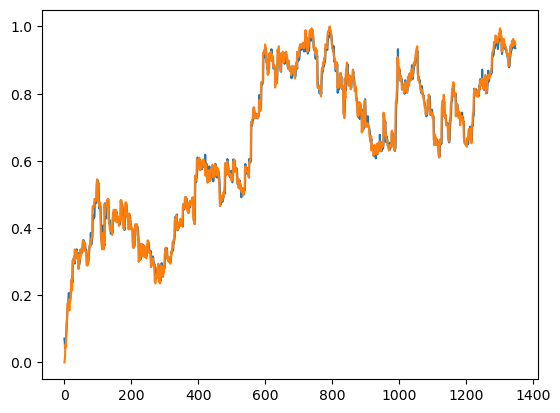

In [598]:
print(mean_squared_error(pred0.flatten(),y_scale))
plt.plot(pred0.flatten())
plt.plot(y_scale)

---

`-` 비교군

In [405]:
# 비교군

K.clear_session()
model_no = Sequential()
model_no.add(LSTM(32, name='lstmd2',input_shape=(5,3)))
model_no.add(Dense(1))
model_no.compile(loss='mean_squared_error', optimizer='adam')

early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0)
model_no.fit(encoder_X1, y_scale, epochs=10,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/10
1349/1349 [==============================] - 3s 1ms/step - loss: 0.0026
Epoch 2/10
1349/1349 [==============================] - 2s 1ms/step - loss: 0.0011
Epoch 3/10
1349/1349 [==============================] - 2s 1ms/step - loss: 8.9504e-04
Epoch 4/10
1349/1349 [==============================] - 2s 1ms/step - loss: 7.9907e-04
Epoch 5/10
1349/1349 [==============================] - 2s 1ms/step - loss: 7.3698e-04
Epoch 6/10
1349/1349 [==============================] - 2s 1ms/step - loss: 6.6593e-04
Epoch 7/10
1349/1349 [==============================] - 2s 1ms/step - loss: 6.2971e-04
Epoch 8/10
1349/1349 [==============================] - 2s 1ms/step - loss: 5.7035e-04
Epoch 9/10
1349/1349 [==============================] - 2s 1ms/step - loss: 5.5261e-04
Epoch 10/10
1349/1349 [==============================] - 2s 1ms/step - loss: 5.6763e-04


# TEST

In [599]:
pred1= model.predict([target_X1, target_X2])
pred2= model_no.predict(contrast)

9/9 [==============================] - 0s 997us/step


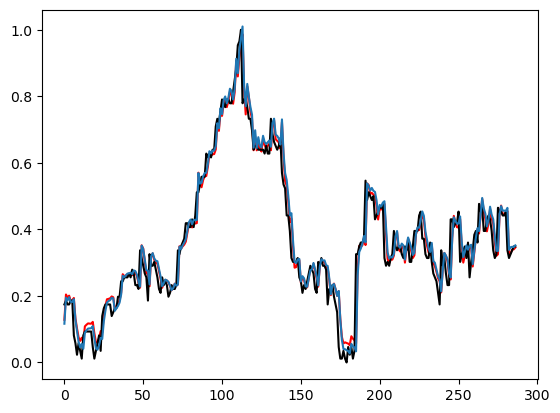

In [600]:
plt.plot(pred1.flatten(),color='red')
plt.plot(target_y_scale,color='black')
plt.plot(pred2.flatten())

In [601]:
from sklearn.metrics import mean_squared_error

print('en-de lstm ',mean_squared_error(target_y_scale,pred1.flatten()))
print('normal lstm',mean_squared_error(target_y_scale,pred2.flatten()))

en-de lstm  0.002736452337118117
normal lstm 0.0029113962903970854
